<a href="https://colab.research.google.com/github/Fazin/mba-data-science-usp/blob/main/TCC_MBA_Routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC - Clustering e otimização de rotas para logística de entrega nas vias da cidade de São Paulo

## Parte 2 - Otimização das rotas

### Bibliotecas

In [ ]:
import numpy as np
from haversine import haversine, Unit
from itertools import combinations
from operator import itemgetter
from tqdm import tqdm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import DistanceMetric
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
from dotenv import load_dotenv
import openrouteservice as ors
import folium
import os

### Carregamento dos grupos já selecionados

In [ ]:
gdf_dbscan1 = pd.read_csv("files/gdf_dbscan1.csv")

### Seleção do grupo a ser estudado

In [ ]:
gdf_dbscan1 = gdf_dbscan1[gdf_dbscan1['color_2'] == 'brown'].reset_index(drop=True)

In [ ]:
data_brown = gdf_dbscan1[gdf_dbscan1['color_2'] == 'brown'][['la_0', 'lo_0']].values

In [ ]:
points = data_brown
# Calculate the centroid of the dataset
centroid = np.mean(points, axis=0)

# Add the centroid as the first point in the list of stops for each route
points = np.vstack((centroid, points))
print(points)

[[-23.55767692 -46.65092566]
 [-23.548814   -46.642782  ]
 [-23.547414   -46.642862  ]
 ...
 [-23.54931948 -46.65401395]
 [-23.5716346  -46.65482008]
 [-23.53434    -46.627524  ]]


/Users/fpassos/Documents/MBA/TCC/code/venv/lib/python3.9/site-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


### Criação da Matriz de Distancias

In [ ]:
def calculate_distance_matrix(points):
    dist = DistanceMetric.get_metric('haversine')
    distances = dist.pairwise(np.radians(points))
    earth_radius = 6371
    distances *= earth_radius
    return distances

### Algoritmo de greedy

In [ ]:
def greedy_algorithm(points, speed_limit, max_time_per_route,time_of_delivery):
    # Calculate pairwise distances between points
    distances = calculate_distance_matrix(points)

    # Initialize route and visited lists
    routes = []
    visited = [False] * len(points)

    # Keep track of total time and current route time
    total_time = 0
    total_distance = 0
    current_route_time = 0
    list_of_distances = []
    list_of_times = []

    # Start at first point
    current_point = 0

    # Visit all points
    while not all(visited):
        # Initialize route with current point
        current_route = [current_point]
        visited[current_point] = True

        # Set current route time to 0
        current_route_time = 0
        current_route_distance = 0


        # Find next closest point and add it to route
        while True:
            # Get distances to unvisited points
            unvisited_distances = distances[current_point][np.logical_not(visited)]
            if len(unvisited_distances) == 0:
                # No unvisited points left, route is complete
                break
            # Find next closest unvisited point
            next_point = np.argmin(unvisited_distances)
            next_point = np.arange(len(points))[np.logical_not(visited)][next_point]
            # Calculate time to travel to next point
            time_to_next_point = time_of_delivery + distances[current_point][next_point] / speed_limit
            # Check if adding next point exceeds maximum time per route
            if current_route_time + time_to_next_point > max_time_per_route:
                break
            # Add next point to route and mark as visited
            current_route.append(next_point)
            visited[next_point] = True
            # Add time to travel to next point to current route time
            current_route_time += time_to_next_point
            current_route_distance += distances[current_point][next_point]
            # print({
            #     "current_route_time":current_route_time,
            #     "time_to_next_point": time_to_next_point,
            #     "distances": distances[current_point][next_point]})
            # Update current point
            current_point = next_point

        # Add current route to list of routes
        routes.append(current_route)
        # Add current route time to total time
        total_time += current_route_time
        total_distance += current_route_distance
        list_of_distances.append(current_route_distance)
        list_of_times.append(current_route_time)

        # Check if there are any unvisited points left
        if not all(visited):
            # Find next unvisited point
            next_point = np.arange(len(points))[np.logical_not(visited)][0]
            # Update current point to next unvisited point
            current_point = next_point

    return routes, total_time, total_distance,list_of_distances,list_of_times


### Criação das rotas com alguns limitantes

In [ ]:
routes, total_time, total_distance,list_of_distances,list_of_times = greedy_algorithm(points, speed_limit=30, max_time_per_route=6, time_of_delivery=15/60)


/Users/fpassos/Documents/MBA/TCC/code/venv/lib/python3.9/site-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


In [ ]:
print(routes)
print(len(routes))
print(list_of_times)

[[0, 72, 71, 61, 62, 28, 29, 46, 36, 830, 576, 569, 302, 304, 123, 179, 158, 159, 157, 242, 243, 245, 831, 794], [1, 532, 554, 372, 788, 722, 308, 523, 672, 686, 639, 641, 637, 633, 645, 711, 727, 815, 829, 610, 594, 11, 433, 450], [2, 3, 4, 5, 257, 252, 344, 356, 239, 323, 18, 19, 21, 182, 117, 103, 496, 408, 410, 442, 439, 597, 516, 621], [6, 334, 7, 810, 795, 8, 9, 79, 80, 789, 809, 671, 724, 769, 770, 574, 622, 538, 833, 625, 754, 747, 748, 696], [10, 13, 14, 406, 423, 447, 448, 763, 699, 778, 758, 486, 487, 504, 808, 628, 642, 623, 707, 668, 536, 160, 483, 717], [12, 585, 469, 464, 519, 520, 521, 752, 745, 691, 692, 693, 744, 774, 685, 281, 244, 26, 165, 25, 30, 561, 583, 140], [15, 131, 170, 127, 102, 77, 89, 65, 669, 51, 49, 643, 361, 368, 657, 613, 564, 546, 340, 339, 335, 325, 351, 463], [16, 226, 228, 225, 230, 817, 823, 824, 825, 505, 501, 485, 599, 507, 219, 221, 222, 326, 327, 305, 341, 233, 235, 247], [17, 687, 636, 680, 646, 588, 584, 537, 534, 503, 491, 445, 286, 269, 2

In [ ]:
try:
    sp = gpd.read_file('files/3550308_Sao Paulo_Setores_2020.kml', driver='KML')
except:
    gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
    sp = gpd.read_file('files/3550308_Sao Paulo_Setores_2020.kml', driver='KML')
sp.head()

Name                                        Description  \
0  355030881000513  <center><table><tr><th colspan='2' align='cent...   
1  355030881000512  <center><table><tr><th colspan='2' align='cent...   
2  355030881000510  <center><table><tr><th colspan='2' align='cent...   
3  355030881000485  <center><table><tr><th colspan='2' align='cent...   
4  355030881000484  <center><table><tr><th colspan='2' align='cent...   

                                            geometry  
0  POLYGON Z ((-46.58348 -23.42321 0.00000, -46.5...  
1  POLYGON Z ((-46.58837 -23.42523 0.00000, -46.5...  
2  POLYGON Z ((-46.57875 -23.37375 0.00000, -46.5...  
3  POLYGON Z ((-46.61870 -23.44363 0.00000, -46.6...  
4  POLYGON Z ((-46.59404 -23.42785 0.00000, -46.5...

In [ ]:
colors = ['green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 'gray', 'olive', 'cyan', 'magenta', 'indigo', 'navy', 'maroon', 'lime', 'teal', 'coral', 'crimson', 'gold', 'silver', 'aqua', 'limegreen', 'lightcoral', 'lightblue', 'lightgreen', 'lightgray', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightsteelblue', 'lightyellow', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'oldlace', 'olivedrab', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip', 'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'skyblue', 'slateblue', 'slategray', 'snow', 'springgreen', 'steelblue', 'tan', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'whitesmoke', 'yellowgreen']
color_dict = {i: colors[i] for i in range(len(colors))}
# color_dict

In [ ]:
colors_2 = ['green', 'lightred', 'beige', 'lightblue', 'white', 'darkred', 'blue', 'pink', 'darkblue', 'red', 'darkgreen', 'lightgray', 'purple', 'darkpurple', 'lightgreen', 'black', 'orange', 'gray', 'cadetblue','green', 'lightred', 'beige', 'lightblue', 'white', 'darkred', 'blue', 'pink', 'darkblue', 'red', 'darkgreen', 'lightgray', 'purple', 'darkpurple', 'lightgreen', 'black', 'orange', 'gray', 'cadetblue','green', 'lightred', 'beige', 'lightblue', 'white', 'darkred', 'blue', 'pink', 'darkblue', 'red', 'darkgreen', 'lightgray', 'purple', 'darkpurple', 'lightgreen', 'black', 'orange', 'gray', 'cadetblue','green', 'lightred', 'beige', 'lightblue', 'white', 'darkred', 'blue', 'pink', 'darkblue', 'red', 'darkgreen', 'lightgray', 'purple', 'darkpurple', 'lightgreen', 'black', 'orange', 'gray', 'cadetblue','green', 'lightred', 'beige', 'lightblue', 'white', 'darkred', 'blue', 'pink', 'darkblue', 'red', 'darkgreen', 'lightgray', 'purple', 'darkpurple', 'lightgreen', 'black', 'orange', 'gray', 'cadetblue','green', 'lightred', 'beige', 'lightblue', 'white', 'darkred', 'blue', 'pink', 'darkblue', 'red', 'darkgreen', 'lightgray', 'purple', 'darkpurple', 'lightgreen', 'black', 'orange', 'gray', 'cadetblue','green', 'lightred', 'beige', 'lightblue', 'white', 'darkred', 'blue', 'pink', 'darkblue', 'red', 'darkgreen', 'lightgray', 'purple', 'darkpurple', 'lightgreen', 'black', 'orange', 'gray', 'cadetblue','green', 'lightred', 'beige', 'lightblue', 'white', 'darkred', 'blue', 'pink', 'darkblue', 'red', 'darkgreen', 'lightgray', 'purple', 'darkpurple', 'lightgreen', 'black', 'orange', 'gray', 'cadetblue']
color_dict_2 = {i: colors_2[i] for i in range(len(colors_2))}
# color_dict_2


In [ ]:
dict_routes = {color_dict[i]:route for i,route in enumerate(routes)}
dict_routes_2 = {color_dict_2[i]:route for i,route in enumerate(routes)}
# dict_routes_2

In [ ]:
routes[0]

[0,
 72,
 71,
 61,
 62,
 28,
 29,
 46,
 36,
 830,
 576,
 569,
 302,
 304,
 123,
 179,
 158,
 159,
 157,
 242,
 243,
 245,
 831,
 794]

In [ ]:
list_colors = []
for i,route in enumerate(routes):
    for j, order in enumerate(route):
        list_colors.append([order,i,j,color_dict[i],color_dict_2[i]])
# list_colors

In [ ]:
pd.DataFrame(list_colors, columns=['id', 'route_id','route_order', 'color', 'color_2']).set_index('id').sort_index().reset_index()

id  route_id  route_order      color    color_2
0      0         0            0      green      green
1      1         1            0       blue   lightred
2      2         2            0     yellow      beige
3      3         2            1     yellow      beige
4      4         2            2     yellow      beige
..   ...       ...          ...        ...        ...
829  829         1           18       blue   lightred
830  830         0            9      green      green
831  831         0           22      green      green
832  832        26           22  lightgray       pink
833  833         3           18     orange  lightblue

[834 rows x 5 columns]

In [ ]:
gdf_dbscan1

la_0       lo_0  cont                             geometry  flag_sp  \
0   -23.548814 -46.642782     7        POINT (-46.642782 -23.548814)     True   
1   -23.547414 -46.642862     8        POINT (-46.642862 -23.547414)     True   
2   -23.547296 -46.642870     9      POINT (-46.6428704 -23.5472962)     True   
3   -23.547296 -46.642870    10      POINT (-46.6428704 -23.5472962)     True   
4   -23.546984 -46.642988    11  POINT (-46.642987624 -23.546983807)     True   
..         ...        ...   ...                                  ...      ...   
828 -23.550298 -46.646075  1991        POINT (-46.646075 -23.550298)     True   
829 -23.555609 -46.654003  1996        POINT (-46.654003 -23.555609)     True   
830 -23.549319 -46.654014  1997  POINT (-46.654013948 -23.549319476)     True   
831 -23.571635 -46.654820  1999    POINT (-46.654820075 -23.5716346)     True   
832 -23.534340 -46.627524   437         POINT (-46.627524 -23.53434)     True   

     cluster color  dbscan_cluster dbscan_color  cluster_2 color_2  
0          8  gray               1         blue          6   brown  
1          8  gray               1         blue          6   brown  
2          8  gray               1         blue          6   brown  
3          8  gray               1         blue          6   brown  
4          8  gray               1         blue          6   brown  
..       ...   ...             ...          ...        ...     ...  
828        8  gray               1         blue          6   brown  
829        8  gray               1         blue          6   brown  
830        8  gray               1         blue          6   brown  
831        8  gray               1         blue          6   brown  
832        8  gray               1         blue          6   brown  

[833 rows x 11 columns]

In [ ]:
gdf_dbscan1[['route_id' ,'route_order', 'route_color', 'route_color_2']]=pd.DataFrame(list_colors, columns=['id','route_id','route_order', 'color', 'color_2']).set_index('id').sort_index().reset_index(drop=True)

In [ ]:
gdf_dbscan1

la_0       lo_0  cont                             geometry  flag_sp  \
0   -23.548814 -46.642782     7        POINT (-46.642782 -23.548814)     True   
1   -23.547414 -46.642862     8        POINT (-46.642862 -23.547414)     True   
2   -23.547296 -46.642870     9      POINT (-46.6428704 -23.5472962)     True   
3   -23.547296 -46.642870    10      POINT (-46.6428704 -23.5472962)     True   
4   -23.546984 -46.642988    11  POINT (-46.642987624 -23.546983807)     True   
..         ...        ...   ...                                  ...      ...   
828 -23.550298 -46.646075  1991        POINT (-46.646075 -23.550298)     True   
829 -23.555609 -46.654003  1996        POINT (-46.654003 -23.555609)     True   
830 -23.549319 -46.654014  1997  POINT (-46.654013948 -23.549319476)     True   
831 -23.571635 -46.654820  1999    POINT (-46.654820075 -23.5716346)     True   
832 -23.534340 -46.627524   437         POINT (-46.627524 -23.53434)     True   

     cluster color  dbscan_cluster dbscan_color  cluster_2 color_2  route_id  \
0          8  gray               1         blue          6   brown         0   
1          8  gray               1         blue          6   brown         1   
2          8  gray               1         blue          6   brown         2   
3          8  gray               1         blue          6   brown         2   
4          8  gray               1         blue          6   brown         2   
..       ...   ...             ...          ...        ...     ...       ...   
828        8  gray               1         blue          6   brown        18   
829        8  gray               1         blue          6   brown         1   
830        8  gray               1         blue          6   brown         0   
831        8  gray               1         blue          6   brown         0   
832        8  gray               1         blue          6   brown        26   

     route_order route_color route_color_2  
0              0       green         green  
1              0        blue      lightred  
2              0      yellow         beige  
3              1      yellow         beige  
4              2      yellow         beige  
..           ...         ...           ...  
828           20     crimson     cadetblue  
829           18        blue      lightred  
830            9       green         green  
831           22       green         green  
832           22   lightgray          pink  

[833 rows x 15 columns]

### Visualizaçao cartesiana das rotas

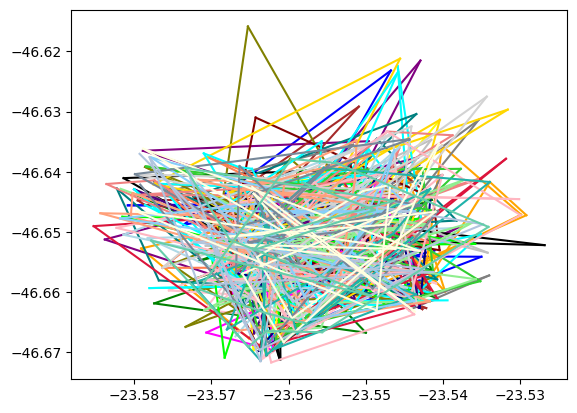

In [ ]:

fig, ax = plt.subplots()
for route_id in set(gdf_dbscan1['route_id']):
    xy = gdf_dbscan1[gdf_dbscan1['route_id'] == route_id].sort_values('route_order')[['la_0', 'lo_0']].values
    # print(xy)

    for start, stop in zip(xy[:-1], xy[1:]):
        x, y = zip(start, stop)
        ax.plot(x, y, color=color_dict[route_id])
ax.autoscale_view()
plt.show()


In [ ]:
gdf_dbscan1[gdf_dbscan1['route_id'] == 1].sort_values('route_order')[['la_0', 'lo_0']].values

array([[-23.547414  , -46.642862  ],
       [-23.5736    , -46.648811  ],
       [-23.546749  , -46.623177  ],
       [-23.560597  , -46.654543  ],
       [-23.543093  , -46.638823  ],
       [-23.567804  , -46.65133   ],
       [-23.562739  , -46.660913  ],
       [-23.5411172 , -46.6530662 ],
       [-23.560673  , -46.642536  ],
       [-23.563337  , -46.6560984 ],
       [-23.5558579 , -46.66156713],
       [-23.551323  , -46.650679  ],
       [-23.54473   , -46.645321  ],
       [-23.565507  , -46.661759  ],
       [-23.56421068, -46.65525971],
       [-23.544069  , -46.645026  ],
       [-23.580804  , -46.645581  ],
       [-23.546795  , -46.645722  ],
       [-23.555609  , -46.654003  ],
       [-23.5350349 , -46.6541182 ],
       [-23.561406  , -46.667024  ],
       [-23.56666   , -46.661018  ],
       [-23.566147  , -46.642628  ],
       [-23.564523  , -46.643651  ]])

In [ ]:
gdf_dbscan1

la_0       lo_0  cont                             geometry  flag_sp  \
0   -23.548814 -46.642782     7        POINT (-46.642782 -23.548814)     True   
1   -23.547414 -46.642862     8        POINT (-46.642862 -23.547414)     True   
2   -23.547296 -46.642870     9      POINT (-46.6428704 -23.5472962)     True   
3   -23.547296 -46.642870    10      POINT (-46.6428704 -23.5472962)     True   
4   -23.546984 -46.642988    11  POINT (-46.642987624 -23.546983807)     True   
..         ...        ...   ...                                  ...      ...   
828 -23.550298 -46.646075  1991        POINT (-46.646075 -23.550298)     True   
829 -23.555609 -46.654003  1996        POINT (-46.654003 -23.555609)     True   
830 -23.549319 -46.654014  1997  POINT (-46.654013948 -23.549319476)     True   
831 -23.571635 -46.654820  1999    POINT (-46.654820075 -23.5716346)     True   
832 -23.534340 -46.627524   437         POINT (-46.627524 -23.53434)     True   

     cluster color  dbscan_cluster dbscan_color  cluster_2 color_2  route_id  \
0          8  gray               1         blue          6   brown         0   
1          8  gray               1         blue          6   brown         1   
2          8  gray               1         blue          6   brown         2   
3          8  gray               1         blue          6   brown         2   
4          8  gray               1         blue          6   brown         2   
..       ...   ...             ...          ...        ...     ...       ...   
828        8  gray               1         blue          6   brown        18   
829        8  gray               1         blue          6   brown         1   
830        8  gray               1         blue          6   brown         0   
831        8  gray               1         blue          6   brown         0   
832        8  gray               1         blue          6   brown        26   

     route_order route_color route_color_2  
0              0       green         green  
1              0        blue      lightred  
2              0      yellow         beige  
3              1      yellow         beige  
4              2      yellow         beige  
..           ...         ...           ...  
828           20     crimson     cadetblue  
829           18        blue      lightred  
830            9       green         green  
831           22       green         green  
832           22   lightgray          pink  

[833 rows x 15 columns]

In [ ]:
# gdf_dbscan1[gdf_dbscan1['color_2'] == 'brown'].plot(ax=sp.plot(figsize=(15, 15)), marker='o', color=gdf_dbscan1['color_2'],markersize=15)
# plt.show()

In [ ]:

load_dotenv()
client = ors.Client(key=os.getenv('OPENROUTE_KEY'))

In [ ]:
gdf_dbscan1

la_0       lo_0  cont                             geometry  flag_sp  \
0   -23.548814 -46.642782     7        POINT (-46.642782 -23.548814)     True   
1   -23.547414 -46.642862     8        POINT (-46.642862 -23.547414)     True   
2   -23.547296 -46.642870     9      POINT (-46.6428704 -23.5472962)     True   
3   -23.547296 -46.642870    10      POINT (-46.6428704 -23.5472962)     True   
4   -23.546984 -46.642988    11  POINT (-46.642987624 -23.546983807)     True   
..         ...        ...   ...                                  ...      ...   
828 -23.550298 -46.646075  1991        POINT (-46.646075 -23.550298)     True   
829 -23.555609 -46.654003  1996        POINT (-46.654003 -23.555609)     True   
830 -23.549319 -46.654014  1997  POINT (-46.654013948 -23.549319476)     True   
831 -23.571635 -46.654820  1999    POINT (-46.654820075 -23.5716346)     True   
832 -23.534340 -46.627524   437         POINT (-46.627524 -23.53434)     True   

     cluster color  dbscan_cluster dbscan_color  cluster_2 color_2  route_id  \
0          8  gray               1         blue          6   brown         0   
1          8  gray               1         blue          6   brown         1   
2          8  gray               1         blue          6   brown         2   
3          8  gray               1         blue          6   brown         2   
4          8  gray               1         blue          6   brown         2   
..       ...   ...             ...          ...        ...     ...       ...   
828        8  gray               1         blue          6   brown        18   
829        8  gray               1         blue          6   brown         1   
830        8  gray               1         blue          6   brown         0   
831        8  gray               1         blue          6   brown         0   
832        8  gray               1         blue          6   brown        26   

     route_order route_color route_color_2  
0              0       green         green  
1              0        blue      lightred  
2              0      yellow         beige  
3              1      yellow         beige  
4              2      yellow         beige  
..           ...         ...           ...  
828           20     crimson     cadetblue  
829           18        blue      lightred  
830            9       green         green  
831           22       green         green  
832           22   lightgray          pink  

[833 rows x 15 columns]

### Visualização das rotas no mapa via Folium

In [ ]:
m = folium.Map(location=centroid, tiles='cartodbpositron', zoom_start=13)

# # Some coordinates in Berlin
coords_dict = { int(i): (gdf_dbscan1[gdf_dbscan1['route_id'] == i].sort_values('route_order')[[ 'lo_0', 'la_0']].values).tolist() for i in gdf_dbscan1['route_id'].unique()}
colors_routes_dict = { int(i): (gdf_dbscan1[gdf_dbscan1['route_id'] == i].sort_values('route_order')[[ 'route_color_2']].values).tolist() for i in gdf_dbscan1['route_id'].unique()}
routes_orders_dict = { int(i): (gdf_dbscan1[gdf_dbscan1['route_id'] == i].sort_values('route_order')[[ 'route_order']].values).tolist() for i in gdf_dbscan1['route_id'].unique()}

# print(coords_dict)



m = folium.Map(location=list(centroid), tiles="cartodbpositron", zoom_start=14)


# for coord in coords_dict[2]:
#     folium.Marker(location=list(reversed(coord))).add_to(m)
# m

full_routes = {}

for i in gdf_dbscan1['route_id'].unique():
    route = client.directions(
        coordinates=coords_dict[i],
        profile='driving-car',
        format='geojson',
        # service=15*60*60
        # options={"avoid_features": ["steps"]},
        # validate=False,
    )
    full_routes[i] = route
    folium.PolyLine(locations=[list(reversed(coord))
                            for coord in
                            route['features'][0]['geometry']['coordinates']], color=colors_routes_dict[i][0]).add_to(m)

    for color, coord in zip(colors_routes_dict[i],coords_dict[i]):
        # print(color[0],coord)
        folium.Marker(location=list(reversed(coord)), icon=folium.Icon(color=color[0])).add_to(m)

# folium.Marker(location=list(centroid), icon=folium.Icon(color="red")).add_to(m)
# m
# vehicles = [
#     ors.optimization.Vehicle(id=i, profile='driving-car')  for i in gdf_dbscan1['route_id'].unique()

# ]
# jobs = [ors.optimization.Job(id=index, location=coords_dict[i], amount=[1]) for i in gdf_dbscan1['route_id'].unique()]
# optimized = client.optimization(jobs=jobs, vehicles=vehicles, geometry=True)
# line_colors = ['green', 'orange', 'blue', 'yellow']
# for route in optimized['routes']:
#     folium.PolyLine(locations=[list(reversed(coords)) for coords in ors.convert.decode_polyline(route['geometry'])['coordinates']], color=line_colors[route['vehicle']]).add_to(m)
m


In [ ]:
df = pd.DataFrame.from_records(pd.DataFrame.from_dict(pd.DataFrame(pd.DataFrame.from_dict(full_routes[0]['features'][0]['properties']['segments'])['steps']))).explode('steps')
df_1 = pd.DataFrame()
# pd.concat([pd.DataFrame.from_records(df.iloc[1,:]),pd.DataFrame.from_records(df.iloc[0,:])], axis=0)
# len(df)
for i in range(len(df)):
    df_1 = pd.concat([df_1,pd.DataFrame.from_records(df.iloc[i,:])], axis=0)
    # print(pd.DataFrame.from_dict(linha)))
df_1['duration'].sum()

9041.2

In [ ]:
full_routes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [ ]:
dict_sum_routes = {i : full_routes[i]['features'][0]['properties']['summary'] for i in full_routes.keys()}
for i in dict_sum_routes.keys():
    dict_sum_routes[i]['distance_km'] = dict_sum_routes[i]['distance']/1000
    dict_sum_routes[i]['duration_hours'] = dict_sum_routes[i]['duration']/(60*60)
    dict_sum_routes[i]['service_hours'] = len(coords_dict[i])*15*60/(60*60)
    dict_sum_routes[i]['service'] = len(coords_dict[i])*15*60
    dict_sum_routes[i]['total_time'] = dict_sum_routes[i]['service_hours'] + dict_sum_routes[i]['duration_hours']
pd.DataFrame(dict_sum_routes).transpose()

distance  duration  distance_km  duration_hours  service_hours  service  \
0    72130.8    9040.3      72.1308        2.511194           6.00  21600.0   
1    75622.9    9873.9      75.6229        2.742750           6.00  21600.0   
2    48771.4    5945.0      48.7714        1.651389           6.00  21600.0   
3    68352.0    8763.9      68.3520        2.434417           5.75  20700.0   
4    68839.2    9051.4      68.8392        2.514278           6.00  21600.0   
5    58100.2    7758.9      58.1002        2.155250           6.00  21600.0   
6    67285.4    8807.8      67.2854        2.446611           6.00  21600.0   
7    60058.8    7299.5      60.0588        2.027639           6.00  21600.0   
8    66200.8    8505.3      66.2008        2.362583           6.00  21600.0   
9    64320.3    8291.8      64.3203        2.303278           6.00  21600.0   
10   71490.9    9744.7      71.4909        2.706861           6.00  21600.0   
11   45827.1    6136.0      45.8271        1.704444           6.00  21600.0   
12   51292.4    6846.7      51.2924        1.901861           6.00  21600.0   
13   61092.2    7554.2      61.0922        2.098389           6.00  21600.0   
14   61355.5    7776.2      61.3555        2.160056           6.00  21600.0   
15   59567.0    7782.7      59.5670        2.161861           6.00  21600.0   
16   76175.8    9924.8      76.1758        2.756889           6.00  21600.0   
17   47215.4    6506.0      47.2154        1.807222           6.00  21600.0   
18   60032.7    7562.3      60.0327        2.100639           6.00  21600.0   
19   60538.3    7799.8      60.5383        2.166611           6.00  21600.0   
20   56409.7    7344.1      56.4097        2.040028           6.00  21600.0   
21   65737.5    8758.8      65.7375        2.433000           6.00  21600.0   
22   65378.8    8268.6      65.3788        2.296833           6.00  21600.0   
23   79172.9   10041.8      79.1729        2.789389           6.00  21600.0   
24   75898.9    9710.8      75.8989        2.697444           6.00  21600.0   
25   67759.2    8460.4      67.7592        2.350111           6.00  21600.0   
26   68979.0    8692.1      68.9790        2.414472           6.00  21600.0   
27   82814.9   10674.3      82.8149        2.965083           6.00  21600.0   
28   64055.4    8410.4      64.0554        2.336222           6.00  21600.0   
29   67414.0    8808.0      67.4140        2.446667           6.00  21600.0   
30   59744.1    8238.4      59.7441        2.288444           6.00  21600.0   
31   55406.3    7298.1      55.4063        2.027250           6.00  21600.0   
32   67729.8    8708.3      67.7298        2.418972           6.00  21600.0   
33   74481.9    9824.2      74.4819        2.728944           6.00  21600.0   
34   46614.4    6224.3      46.6144        1.728972           4.50  16200.0   

    total_time  
0     8.511194  
1     8.742750  
2     7.651389  
3     8.184417  
4     8.514278  
5     8.155250  
6     8.446611  
7     8.027639  
8     8.362583  
9     8.303278  
10    8.706861  
11    7.704444  
12    7.901861  
13    8.098389  
14    8.160056  
15    8.161861  
16    8.756889  
17    7.807222  
18    8.100639  
19    8.166611  
20    8.040028  
21    8.433000  
22    8.296833  
23    8.789389  
24    8.697444  
25    8.350111  
26    8.414472  
27    8.965083  
28    8.336222  
29    8.446667  
30    8.288444  
31    8.027250  
32    8.418972  
33    8.728944  
34    6.228972

In [ ]:
dict_sum_routes[25]['total_time']/(60*60)

0.0023194753086419754

In [ ]:
# m = folium.Map(location=centroid, tiles='cartodbpositron', zoom_start=13)



m = folium.Map(location=list(centroid), tiles="cartodbpositron", zoom_start=14)


# for coord in coords_dict[2]:
#     folium.Marker(location=list(reversed(coord))).add_to(m)
# m

route = client.directions(
    coordinates=coords_dict[0],
    profile='driving-car',
    format='geojson',
    # options={"avoid_features": ["steps"]},
    # validate=False,
)
full_routes[0] = route
folium.PolyLine(locations=[list(reversed(coord))
                        for coord in
                        route['features'][0]['geometry']['coordinates']], color=colors_routes_dict[0][0]).add_to(m)

for color, coord in zip(colors_routes_dict[0],coords_dict[0]):
    # print(color[0],coord)
    folium.Marker(location=list(reversed(coord)), icon=folium.Icon(color=color[0])).add_to(m)

# folium.Marker(location=list(centroid), icon=folium.Icon(color="red")).add_to(m)
# m
vehicles = [
    ors.optimization.Vehicle(id=i, profile='driving-car', time_window=[0,8*60*60])  for i in gdf_dbscan1['route_id'].unique()

]
jobs = [ors.optimization.Job(id=index, location=coords, amount=[1]) for index, coords in enumerate((gdf_dbscan1[[ 'lo_0', 'la_0']].values).tolist())]
# optimized = client.optimization(jobs=jobs, vehicles=vehicles, geometry=True)
# # line_colors = ['green', 'orange', 'blue', 'yellow']
# for route in optimized['routes']:
#     folium.PolyLine(locations=[list(reversed(coords)) for coords in ors.convert.decode_polyline(route['geometry'])['coordinates']], color=colors_2[route['vehicle']]).add_to(m)
m

### Otimização das rotas via openrouteservice e visualização

In [ ]:
import math
optimizeds = {}
for i in coords_dict.keys():
    coords = [
        { 'location': coord, 'service': 15*60 } for coord in coords_dict[i]
    ]
    print(coords)
    vehicle_start = list(reversed(centroid))
    m = folium.Map(location=list(centroid), tiles="cartodbpositron", zoom_start=14)

    folium.Marker(location=list(reversed(vehicle_start)), icon=folium.Icon(color="red")).add_to(m)
    # m

    vehicles = [
        # ors.optimization.Vehicle(id=i, profile='driving-car', start=centroid, end=centroid, time_window=[0, 8*60*60]) for i in range(28)
        ors.optimization.Vehicle(id=i, profile='driving-car', start=vehicle_start, end=vehicle_start, time_window=[0, 8*60*60])
    ]
    # print(vehicles)
    jobs = [ors.optimization.Job(id=index, **job) for index, job in enumerate(coords)]
    # print(jobs)
    optimized = client.optimization(jobs=jobs, vehicles=vehicles, geometry=True)
    optimizeds[i] = optimized
# line_colors = ['green', 'orange', 'blue', 'yellow']
for i in optimizeds.keys():
    for route in optimizeds[i]['routes']:
        folium.PolyLine(locations=[list(reversed(coords)) for coords in ors.convert.decode_polyline(route['geometry'])['coordinates']], color=colors_2[i]).add_to(m)
        for step in route['steps']:
            if not step['type'] == 'job':
                continue
            folium.Marker(location=list(reversed(step['location'])), popup=f"Arrival time: {math.floor(step['arrival'] / (60*60))} hours {math.floor((step['arrival'] % (60*60)) / 60)} minutes", icon=folium.Icon(color=colors_2[route['vehicle']])).add_to(m)
m

[{'location': [-46.642782, -23.548814], 'service': 900}, {'location': [-46.656353, -23.541378], 'service': 900}, {'location': [-46.651294, -23.55717], 'service': 900}, {'location': [-46.65233817, -23.557006741], 'service': 900}, {'location': [-46.660672, -23.549448], 'service': 900}, {'location': [-46.652565, -23.556372], 'service': 900}, {'location': [-46.661868, -23.577395], 'service': 900}, {'location': [-46.666734, -23.549986], 'service': 900}, {'location': [-46.646977, -23.564784], 'service': 900}, {'location': [-46.654013948, -23.549319476], 'service': 900}, {'location': [-46.6447, -23.565962], 'service': 900}, {'location': [-46.660897, -23.540924], 'service': 900}, {'location': [-46.652473, -23.561233], 'service': 900}, {'location': [-46.652804, -23.56338], 'service': 900}, {'location': [-46.643587, -23.580208], 'service': 900}, {'location': [-46.660162, -23.546234], 'service': 900}, {'location': [-46.6546297, -23.551865], 'service': 900}, {'location': [-46.650167, -23.549502], 

In [ ]:
optimizeds[0]['summary']

{'cost': 3870,
 'unassigned': 0,
 'service': 21600,
 'duration': 3870,
 'waiting_time': 0,
 'distance': 27997,
 'computing_times': {'loading': 201, 'solving': 17, 'routing': 114}}

### Comparativo das duas modalidades de otimização

In [ ]:
dict_sum_routes_2 = {}
for i in optimizeds.keys():
    dict_sum_routes_2[i] = optimizeds[i]['summary']
    dict_sum_routes_2[i]['distance_km'] = dict_sum_routes_2[i]['distance']/1000
    dict_sum_routes_2[i]['duration_hours'] = dict_sum_routes_2[i]['duration']/(60*60)
    dict_sum_routes_2[i]['service_hours'] = len(coords_dict[i])*15*60/(60*60)
    dict_sum_routes_2[i]['service'] = len(coords_dict[i])*15*60
    dict_sum_routes_2[i]['total_time'] = dict_sum_routes_2[i]['service_hours'] + dict_sum_routes_2[i]['duration_hours']
pd.DataFrame(dict_sum_routes_2).transpose()

cost unassigned service duration waiting_time distance  \
0   3870          0   21600     3870            0    27997   
1   4524          0   21600     4524            0    29656   
2   3209          0   21600     3209            0    24453   
3   4097          0   20700     4097            0    28324   
4   4860          0   21600     4860            0    34083   
5   3358          0   21600     3358            0    23393   
6   3950          0   21600     3950            0    26452   
7   3859          0   21600     3859            0    28957   
8   4661          0   21600     4661            0    33182   
9   4592          0   21600     4592            0    34991   
10  4554          0   21600     4554            0    32381   
11  3033          0   21600     3033            0    20826   
12  3946          0   21600     3946            0    25480   
13  3224          0   21600     3224            0    21912   
14  3986          0   21600     3986            0    27442   
15  4327          0   21600     4327            0    29413   
16  4454          0   21600     4454            0    30674   
17  3678          0   21600     3678            0    24674   
18  4407          0   21600     4407            0    31267   
19  4519          0   21600     4519            0    31916   
20  3849          0   21600     3849            0    27658   
21  4999          0   21600     4999            0    33224   
22  4025          0   21600     4025            0    29478   
23  4358          0   21600     4358            0    30228   
24  4423          0   21600     4423            0    30133   
25  4374          0   21600     4374            0    29929   
26  4519          0   21600     4519            0    31448   
27  4690          0   21600     4690            0    29915   
28  4208          0   21600     4208            0    28403   
29  4009          0   21600     4009            0    26687   
30  4781          0   21600     4781            0    31071   
31  3910          0   21600     3910            0    26740   
32  4102          0   21600     4102            0    27884   
33  4573          0   21600     4573            0    29406   
34  3752          0   16200     3752            0    26480   

                                    computing_times distance_km  \
0   {'loading': 201, 'solving': 17, 'routing': 114}      27.997   
1    {'loading': 153, 'solving': 6, 'routing': 106}      29.656   
2    {'loading': 151, 'solving': 5, 'routing': 116}      24.453   
3    {'loading': 149, 'solving': 7, 'routing': 109}      28.324   
4   {'loading': 206, 'solving': 10, 'routing': 111}      34.083   
5    {'loading': 157, 'solving': 7, 'routing': 105}      23.393   
6    {'loading': 152, 'solving': 6, 'routing': 131}      26.452   
7    {'loading': 192, 'solving': 6, 'routing': 103}      28.957   
8    {'loading': 188, 'solving': 7, 'routing': 108}      33.182   
9    {'loading': 187, 'solving': 7, 'routing': 103}      34.991   
10   {'loading': 190, 'solving': 7, 'routing': 106}      32.381   
11   {'loading': 157, 'solving': 6, 'routing': 105}      20.826   
12   {'loading': 124, 'solving': 8, 'routing': 110}       25.48   
13   {'loading': 150, 'solving': 6, 'routing': 104}      21.912   
14   {'loading': 157, 'solving': 8, 'routing': 113}      27.442   
15  {'loading': 170, 'solving': 12, 'routing': 107}      29.413   
16   {'loading': 166, 'solving': 7, 'routing': 107}      30.674   
17  {'loading': 146, 'solving': 14, 'routing': 107}      24.674   
18   {'loading': 146, 'solving': 6, 'routing': 108}      31.267   
19   {'loading': 145, 'solving': 8, 'routing': 110}      31.916   
20   {'loading': 171, 'solving': 8, 'routing': 114}      27.658   
21   {'loading': 180, 'solving': 7, 'routing': 114}      33.224   
22   {'loading': 184, 'solving': 8, 'routing': 110}      29.478   
23   {'loading': 160, 'solving': 8, 'routing': 103}      30.228   
24   {'loading': 186, 'solving': 8, 'routing': 107}      30.133   
25   {'loading': 162, 'solvin

In [ ]:
df_fim = pd.concat([pd.DataFrame(dict_sum_routes_2).transpose(),pd.DataFrame(dict_sum_routes).transpose()],axis=1)

In [ ]:
df_analise = df_fim[['distance_km', 'duration_hours', 'service_hours', 'total_time']]
df_analise.columns =['distance_km','distance_km_2', 'duration_hours','duration_hours_2', 'service_hours','service_hours_2', 'total_time', 'total_time_2']

In [ ]:
df_analise['delta'] = df_analise['total_time_2'] - df_analise['total_time']
df_analise['delta'].median()

/var/folders/s_/_9n926q95_x9v_rx3556m3js5996n4/T/ipykernel_1784/742862481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analise['delta'] = df_analise['total_time_2'] - df_analise['total_time']


1.159194444444445

In [ ]:
df_analise['total_time'].median()

8.303277777777778

In [ ]:
df_analise['total_time'].median()

7.168888888888889

In [ ]:
(gdf_dbscan1[[ 'lo_0', 'la_0']].values).tolist()

[[-46.642782, -23.548814],
 [-46.642862, -23.547414],
 [-46.6428704, -23.5472962],
 [-46.6428704, -23.5472962],
 [-46.642987624, -23.546983807],
 [-46.6433101, -23.5460491],
 [-46.642558, -23.545866],
 [-46.641446, -23.544363],
 [-46.6406466, -23.5433581],
 [-46.643662, -23.547859],
 [-46.6453498, -23.5487563],
 [-46.661018, -23.56666],
 [-46.643841, -23.548861],
 [-46.643841, -23.548861],
 [-46.6597342, -23.5648337],
 [-46.653231568, -23.564484198],
 [-46.6558703, -23.5623478],
 [-46.640713, -23.548502],
 [-46.640713, -23.548502],
 [-46.657869, -23.564011],
 [-46.640197, -23.547992],
 [-46.65803, -23.564315],
 [-46.6617176, -23.5435084],
 [-46.661549163, -23.543709553],
 [-46.659325, -23.578005],
 [-46.659722, -23.575486],
 [-46.660429, -23.564009],
 [-46.6523556, -23.5564854],
 [-46.652565, -23.556372],
 [-46.661868, -23.577395],
 [-46.654595, -23.566302],
 [-46.643366, -23.560293],
 [-46.6467638, -23.5644093],
 [-46.64712, -23.564588],
 [-46.647033, -23.564695],
 [-46.653543, -23.55